# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import *
from polytope_utils import *

import warnings

warnings.filterwarnings("ignore")
# np.random.seed(100)
# %load_ext autoreload
# %autoreload 2
notebook_name = "Nonnegative_Antisparse_Copula"

In [2]:
seed_ = np.random.randint(50000)
# seed_ = 22168
np.random.seed(seed_)
print('Seed is : {}'.format(seed_))

Seed is : 42215


# Source Generation and Mixing Scenario

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

# NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(
    rho=rho,
    df=4,
    n_sources=NumberofSources,
    size_sources=N,
    decreasing_correlation=False,
)

INPUT_STD = 0.28
# A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)
A1 = np.random.standard_normal(size=(NumberofMixtures, NumberofSources))
X1 = A1 @ S
A2 = A1.copy()
for M in range(A1.shape[0]):
    stdx = np.std(X1[M, :])
    A2[M, :] = A2[M, :] / stdx * INPUT_STD
X2 = A2 @ S
X = (INPUT_STD * (X1 / X1.std(1)[:,np.newaxis]))
X = X1.copy()
A = A2.copy()
SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))
X = (INPUT_STD * (X / X.std(1)[:,np.newaxis]))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.997404477688058


# Visualize Generated Sources and Mixtures

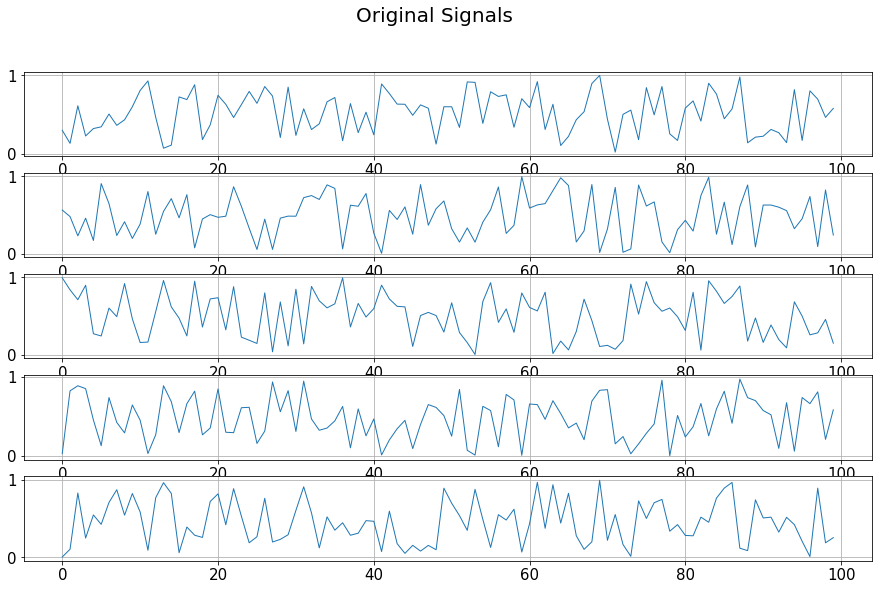

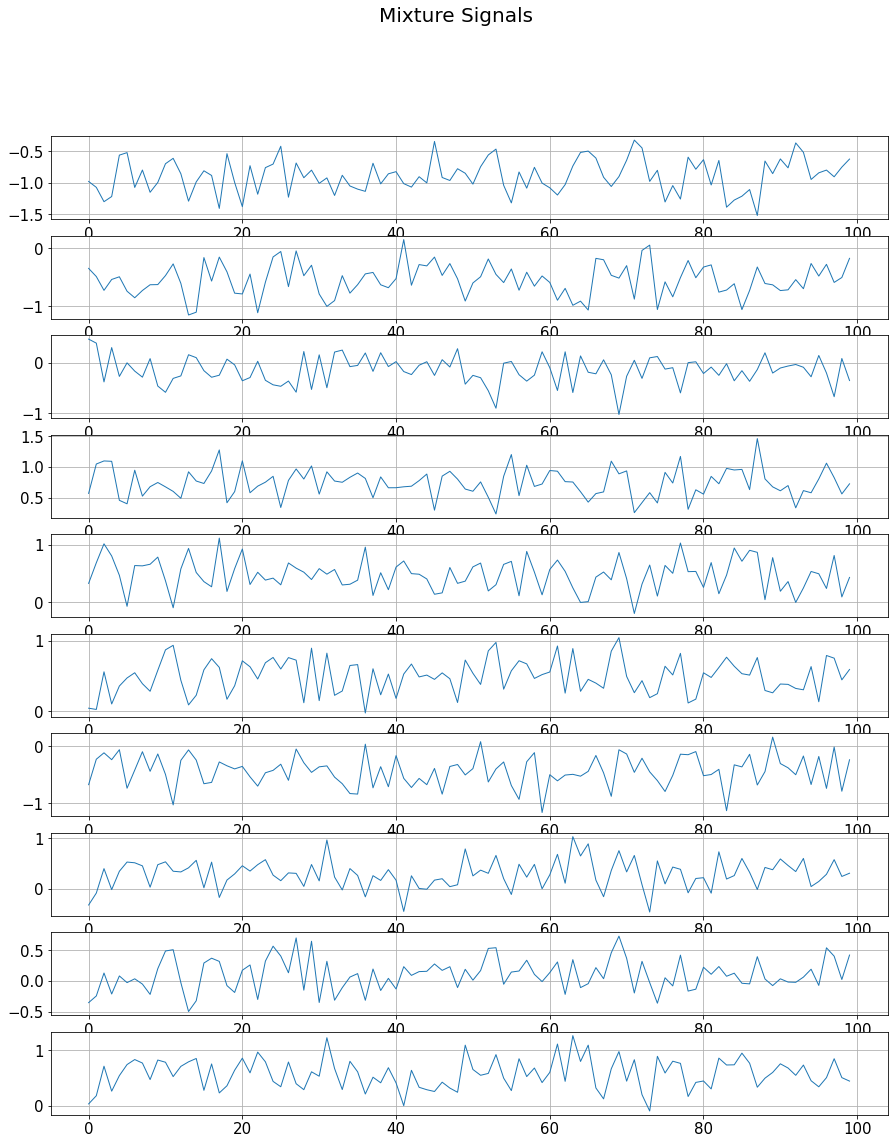

In [4]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
if rho > 0.4:
    gamma_start = 0.05
    gamma_stop = 5 * 1e-4
else:
    gamma_start = 0.1
    gamma_stop = 1e-3

gammaM_start = [gamma_start, gamma_start]
gammaM_stop = [gamma_stop, gamma_stop]
gammaW_start = [gamma_start, gamma_start]
gammaW_stop = [gamma_stop, gamma_stop]

OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS = 3000
LayerGains = [1, 1]
LayerMinimumGains = [1e-3, 1e-3]
LayerMaximumGains = [1e6, 20]
WScalings = [0.0033, 0.0033]
GamScalings = [2, 1]
zeta = 1 * 1e-5
beta = 0.5
muD = [1, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

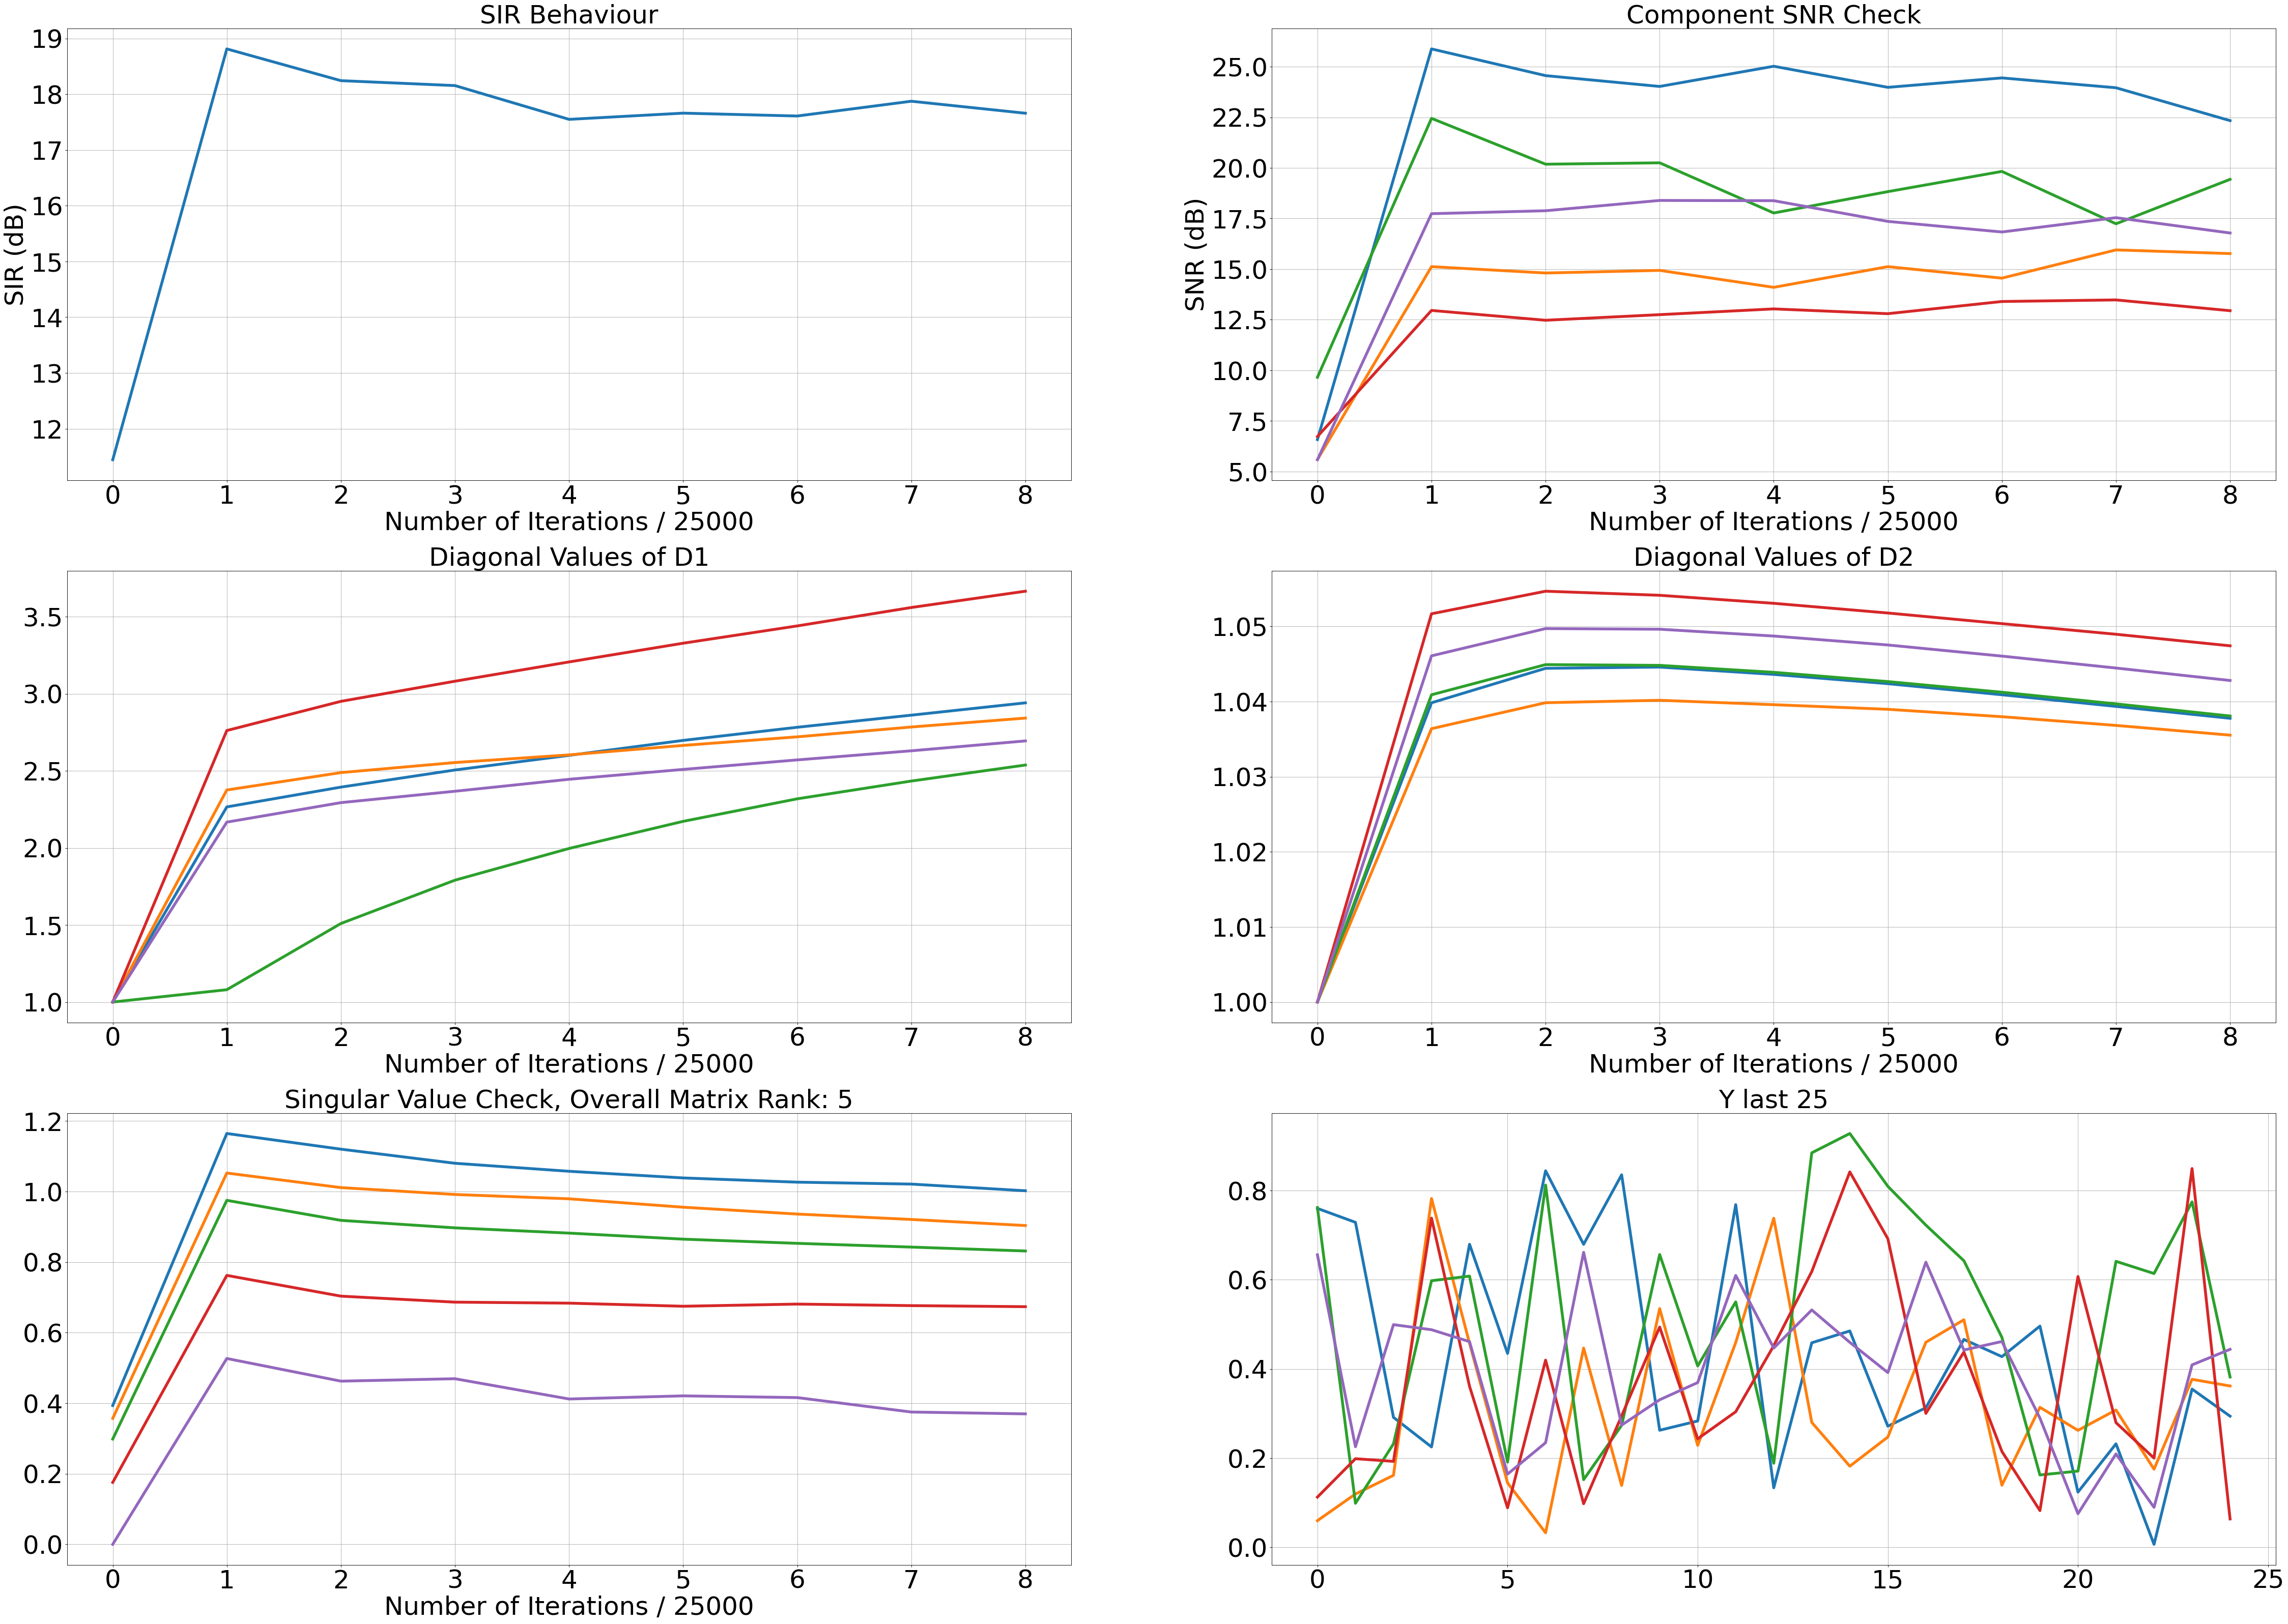

 42%|████▏     | 209376/500000 [09:34<11:03, 438.28it/s] 

In [ ]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSS(
    s_dim=s_dim,
    x_dim=x_dim,
    h_dim=h_dim,
    gammaM_start=gammaM_start,
    gammaM_stop=gammaM_stop,
    gammaW_start=gammaW_start,
    gammaW_stop=gammaW_stop,
    beta=beta,
    zeta=zeta,
    muD=muD,
    WScalings=WScalings,
    GamScalings=GamScalings,
    W_HX=W_HX,
    W_YH=W_YH,
    DScalings=LayerGains,
    LayerMinimumGains=LayerMinimumGains,
    LayerMaximumGains=LayerMaximumGains,
    neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
    set_ground_truth=True,
    S=S,
    A=A,
)

modelWSM.fit_batch_nnantisparse(
    X,
    n_epochs=1,
    neural_dynamic_iterations=500,
    neural_lr_start=0.5,
    neural_lr_stop=0.05,
    synaptic_lr_rule="divide_by_log_index",
    neural_loop_lr_rule="divide_by_slow_loop_index",
    synaptic_lr_decay_divider=1,
    neural_lr_decay_multiplier=0.005,
    hidden_layer_gain=10,
    clip_gain_gradients=True,
    gain_grads_clipping_multiplier = 1,
    use_newton_steps_for_gains = False,
    shuffle=True,
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    modelWSM.SNR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)